# Instructions for Project 1 - Sentiment Analysis

Hello everyone, this is Zhaowei Wang. I am glad to host the first project. My email is *zwanggy@connect.ust.hk*. Feel free to send me an email if you have any problem regarding this project.

In this project, you will try to work on a sentiment analysis task.
You will build a model to predict the scores (a.k.a. the "label" column in datasets, from 1 to 5) of each review.
For each review, you are given a piece of text. You can consider the predicted variables as categorical, ordinal or numerical.

Just a kind note: The codes and techniques introduced in the previous tutorials may come in handy. You can refer to the .ipynb notebooks for details.

## Important dates, submission requirements and grading policy
**Important dates:**
- *March 16, 2024 (Saturday)*: Project starts
- *March 23, 2024 (Saturday)* Release the validation score of baselines
- *April 6, 2024, 23:59 (Saturday)*: `Submission Deadline`

**Submission requirements:**  
Each team leader is required to submit the groupNo.zip file on the Canvas. It shoud contain
- `pred.csv`: Predictions on test data (please make sure you can successfully evaluate your validation predictions on the validation data with the help of evaluate.py). The file should contain two so-called columns, which are `id`
and `label`.
- report (1-2 pages of pdf)
- code (Frameworks and programming languages are not restricted)

**Grading policy:**  
We will check your report with your code and your model performance (in terms of Accuracy) on the test set.

| Grade | Classifier (80%)                                                   | Report (20%)                      |
|-------|--------------------------------------------------------------------|-----------------------------------|
| 50%   | Example code in tutorials or in Project 1 without any modification | submission                        |
| 75%   | A method that can outperform the easy baseline  | algorithm you used                |
| 95%   | A method that can outperform the hard baseline                     | detailed explanation and analysis, such as explorative data analysis, hyperparameters and ablation studies  |
| 100%  | A method that can outperform the hard baseline with at least one excellent idea  | excellent ideas, detailed explanation and solid analysis |

## Instruction Content
In this notebook, you are provided with the code snippets to start with.

The content follows previous lectures and tutorials. But some potentially useful python packages are also mentioned.

1. Loading data and saving predictions
    1. Loading data
    1. Saving predictions to file
1. Preprocessing
    1. Text data processing recap
    1. Explorative data analysis
1. Learning Baselines

## 1. Loading data and saving predictions

The same as previous tutorials, we use `pandas` as the basic tool to load & dump the data.
The key ingredient of our operation is the `DataFrame` in pandas.

In [ ]:
import pandas as pd

In [ ]:
# if you use Google Colab, un-comment this cell, modify `path_to_data` if needed, and run to mount data to `data`
from google.colab import drive
drive.mount('/content/drive')

path_to_data = '/content/drive/My Drive/code/COMP4332/Project 1_Sentiment_Analysis/Project 1_Sentiment_Analysis/data'
!rm -f data
!ln -s '/content/drive/My Drive/code/COMP4332/Project 1_Sentiment_Analysis/Project 1_Sentiment_Analysis/data' data

##Bi-LSTM

In [ ]:
def load_data(split_name='train', columns=['id', 'text', 'label'], folder='data'):
    '''
        "split_name" may be set as 'train', 'valid' or 'test' to load the corresponding dataset.

        You may also specify the column names to load any columns in the .csv data file.
        Among many, "text" can be used as model input, and "label" column is the labels (sentiment).
    '''
    try:
        print(f"select [{', '.join(columns)}] columns from the {split_name} split")
        df = pd.read_csv(f'{folder}/{split_name}.csv')
        df = df.loc[:,columns]
        print("Success")
        return df
    except:
        print(f"Failed loading specified columns... Returning all columns from the {split_name} split")
        df = pd.read_csv(f'{folder}/{split_name}.csv')
        return df

In [ ]:
train_df = load_data('train', columns=['id', 'text', 'label'], folder='data')
valid_df = load_data('valid', columns=['id', 'text', 'label'], folder='data')
# the test set labels (the 'label' column) are unavailable! So the following code will instead return all columns
test_df = load_data('test_no_label', columns=['id', 'text'], folder='data')

In [ ]:
!pip install symspellpy

In [ ]:
!pip install sparknlp
!pip install pyspark

In [ ]:
import os
import nltk
import math
import pandas as pd
import numpy as np
import tensorflow as tf
import keras
import matplotlib.pyplot as plt
from collections import Counter
from itertools import chain
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score
from keras.models import Sequential, Model
from keras.layers import Dense, Activation, Embedding, Dropout, BatchNormalization, Input, Add, Concatenate,\
    Bidirectional, SimpleRNN, LSTM, GRU
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
import string

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')


stopwords = set(stopwords.words("english"))
ps = PorterStemmer()
lemmatizer = WordNetLemmatizer()

In [ ]:
from textblob import TextBlob
from symspellpy import SymSpell, Verbosity
import sparknlp
import re
import spacy
nlp = spacy.load('en_core_web_sm')
def spellingcorrection(tokens:list):
  symspell = SymSpell()
  correct_spellings = []
  for token in tokens:
      x = symspell.lookup(token,Verbosity.CLOSEST,max_edit_distance=2,include_unknown=True)[0].__str__()
      y = x.split(',')[0]
      correct_spellings.append(y)
  return correct_spellings

def lemmatize(tokens:list):
  return [lemmatizer.lemmatize(word) for word in tokens]

def punctuationRemoval(s:str):
  s = s.translate(str.maketrans('', '', string.punctuation))
  return s
def partialpunctuationRemoval(s:str):
  #s = s.translate(str.maketrans('', '', "\"#$%&'*+,-./<=>@[\]^_`{|}~"))
  s = s.translate(str.maketrans('', '', ",."))
  return s
def hyperlinksRemoval(s:str):
  s_processed = re.sub(r'^https?:\/\/.*[\r\n]*', '', s, flags=re.MULTILINE)
  p = re.compile(r'<.*?>')
  return p.sub("",s_processed)
def lower(s):
    """
    :param s: a string.
    return a string with lower characters
    Note that we allow the input to be nested string of a list.
    e.g.
    Input: 'Text mining is to identify useful information.'
    Output: 'text mining is to identify useful information.'
    """
    if isinstance(s, list):
        return [lower(t) for t in s]
    if isinstance(s, str):
        return s.lower()
    else:
        raise NotImplementedError("unknown datatype")

def tokenize(text):
    """
    :param text: a doc with multiple sentences, type: str
    return a word list, type: list
    e.g.
    Input: 'Text mining is to identify useful information.'
    Output: ['Text', 'mining', 'is', 'to', 'identify', 'useful', 'information', '.']
    """
    return nltk.word_tokenize(text)

def stem(tokens):
    """
    :param tokens: a list of tokens, type: list
    return a list of stemmed words, type: list
    e.g.
    Input: ['Text', 'mining', 'is', 'to', 'identify', 'useful', 'information', '.']
    Output: ['text', 'mine', 'is', 'to', 'identifi', 'use', 'inform', '.']
    """
    ### equivalent code
    # results = list()
    # for token in tokens:
    #     results.append(ps.stem(token))
    # return results

    return [ps.stem(token) for token in tokens]

def n_gram(tokens:list, n=1):
    """
    :param tokens: a list of tokens, type: list
    :param n: the corresponding n-gram, type: int
    return a list of n-gram tokens, type: list
    e.g.
    Input: ['text', 'mine', 'is', 'to', 'identifi', 'use', 'inform', '.'], 2
    Output: ['text mine', 'mine is', 'is to', 'to identifi', 'identifi use', 'use inform', 'inform .']
    """
    if n == 1:
      return tokens
    else:
      results = list()
      for i in range(len(tokens)-n+1):
          # tokens[i:i+n] will return a sublist from i th to i+n th (i+n th is not included)
          results.append(" ".join(str(v) for v in tokens[i:i+n]))
      return results

def filter_stopwords(tokens):
    """
    :param tokens: a list of tokens, type: list
    return a list of filtered tokens, type: list
    e.g.
    Input: ['text', 'mine', 'is', 'to', 'identifi', 'use', 'inform', '.']
    Output: ['text', 'mine', 'identifi', 'use', 'inform', '.']
    """
    ### equivalent code
    # results = list()
    # for token in tokens:
    #     if token not in stopwords and not token.isnumeric():
    #         results.append(token)
    # return results

    return [token for token in tokens if token not in stopwords and not token.isnumeric()]

import numpy as np

def get_onehot_vector(feats, feats_dict):
    """
    :param data: a list of features, type: list
    :param feats_dict: a dict from features to indices, type: dict
    return a feature vector,
    """
    # initialize the vector as all zeros
    vector = np.zeros(len(feats_dict), dtype=np.float)
    for f in feats:
        # get the feature index, return -1 if the feature is not existed
        f_idx = feats_dict.get(f, -1)
        if f_idx != -1:
            # set the corresponding element as 1
            vector[f_idx] = 1
    return vector

def get_index_vector(feats, feats_dict, max_len):
    """
    :param feats: a list of features, type: list
    :param feats_dict: a dict from features to indices, type: dict
    :param feats: a list of features, type: list
    return a feature vector,
    """
    # initialize the vector as all zeros
    vector = np.zeros(max_len, dtype=np.int64)
    for i, f in enumerate(feats):
        if i == max_len:
            break
        # get the feature index, return 1 (<unk>) if the feature is not existed
        f_idx = feats_dict.get(f, 1)
        vector[i] = f_idx
    return vector

In [ ]:
def get_feats_dict(feats, min_freq=-1, max_freq=-1, max_size=-1):
    """
    :param data: a list of features, type: list(list)
    :param min_freq: the lowest fequency that the fequency of a feature smaller than it will be filtered out, type: int
    :param max_freq: the highest fequency that the fequency of a feature larger than it will be filtered out, type: int
    :param max_size: the max size of feature dict, type: int
    return a feature dict that maps features to indices, sorted by frequencies
    # Counter document: https://docs.python.org/3.6/library/collections.html#collections.Counter
    """
    # count all features
    feat_cnt = Counter(feats) # ["text", "text", "mine"] --> {"text": 2, "mine": 1}
    if max_size > 0 and min_freq == -1 and max_freq == -1:
        valid_feats = ["<pad>", "<unk>"] + [f for f, cnt in feat_cnt.most_common(max_size-2)]
    else:
        valid_feats = ["<pad>", "<unk>"]
        for f, cnt in feat_cnt.most_common():
            if (min_freq == -1 or cnt >= min_freq) and \
                (max_freq == -1 or cnt <= max_freq):
                valid_feats.append(f)
    if max_size > 0 and len(valid_feats) > max_size:
        valid_feats = valid_feats[:max_size]
    print("Size of features:", len(valid_feats))

    # build a mapping from features to indices
    feats_dict = dict(zip(valid_feats, range(len(valid_feats))))
    return feats_dict

In [ ]:
def build_RNN(input_length, vocab_size, embedding_size,hidden_size, output_size,
              num_rnn_layers, num_mlp_layers,activation="tanh",
              dropout_rate=0.0,l2_reg=0.001,
              optimizer="Adam",learning_rate=0.001,
              metric="accuracy"):
    x = Input(shape=(input_length,))

    emb = Embedding(input_dim=vocab_size,output_dim=embedding_size,
        input_length=input_length, embeddings_initializer=keras.initializers.TruncatedNormal(mean=0.0, stddev=0.1, seed=0))(x)


    fn = LSTM
    h = emb
    for i in range(num_rnn_layers):
        is_last = (i == num_rnn_layers-1)

        h = keras.layers.Bidirectional(fn(hidden_size,
                kernel_initializer=keras.initializers.glorot_uniform(seed=0),
                recurrent_initializer=keras.initializers.Orthogonal(gain=1.0, seed=0),
                return_sequences=not is_last))(h)
        h = Dropout(dropout_rate, seed=0)(h)

    for i in range(num_mlp_layers-1):
        new_h = Dense(hidden_size,kernel_initializer=keras.initializers.he_normal(seed=0),
              bias_initializer="zeros",kernel_regularizer=keras.regularizers.l2(l2_reg))(h)

        new_h = BatchNormalization()(new_h)

        if i == 0:
            h = new_h
        else:
            h = Add()([h, new_h])
        h = Activation(activation)(h)
    y = Dense(output_size,activation="softmax",kernel_initializer=keras.initializers.he_normal(seed=0),bias_initializer="zeros")(h)


    optmizer = keras.optimizers.Adam(learning_rate=learning_rate)
    model = Model(x, y)
    model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=[metric])

    return model

In [ ]:
def negate_text(text):
    negation_words = ['not', "n't"]
    words = text.split()
    negated_words = []
    negating = False

    for word in words:
        if any(neg in word.lower() for neg in negation_words):
            negating = True
            negated_words.append('NOT_' + word)
        elif re.match(r'\w+[.!?]', word):
            # If punctuation encountered, stop negating
            negated_words.append(word)
            negating = False
        elif negating:
            negated_words.append('NOT_' + word)
        else:
            negated_words.append(word)

    return ' '.join(negated_words)

In [ ]:
train_labels = train_df['label'].values
valid_labels = valid_df['label'].values

train_feats = train_df['text'].map(hyperlinksRemoval).map(lower).map(negate_text).map(partialpunctuationRemoval).map(tokenize).map(filter_stopwords).map(lemmatize)
valid_feats = valid_df['text'].map(hyperlinksRemoval).map(lower).map(negate_text).map(partialpunctuationRemoval).map(tokenize).map(filter_stopwords).map(lemmatize)

In [ ]:
# build a mapping from features to indices
min_freq = 0
feats_dict = get_feats_dict(
    chain.from_iterable(train_feats),
    min_freq=min_freq)
print("feats_dict:", feats_dict)

Size of features: 22811
feats_dict: {'<pad>': 0, '<unk>': 1, 'movie': 2, '!': 3, 'NOT_not': 4, "'s": 5, 'good': 6, "n't": 7, 'great': 8, 'NOT_the': 9, 'one': 10, 'time': 11, 'film': 12, 'NOT_it': 13, 'love': 14, 'story': 15, 'like': 16, 'NOT_a': 17, 'watch': 18, 'NOT_to': 19, "''": 20, 'NOT_of': 21, 'NOT_this': 22, 'classic': 23, 'dvd': 24, 'NOT_i': 25, 'would': 26, 'really': 27, 'well': 28, 'NOT_as': 29, 'NOT_but': 30, 'acting': 31, '?': 32, '``': 33, 'NOT_and': 34, 'NOT_was': 35, 'see': 36, 'old': 37, 'better': 38, 'NOT_do': 39, 'best': 40, 'still': 41, 'watching': 42, 'NOT_in': 43, 'much': 44, 'actor': 45, 'NOT_for': 46, 'fun': 47, 'NOT_movie': 48, ')': 49, 'NOT_did': 50, 'year': 51, 'funny': 52, 'first': 53, 'get': 54, 'NOT_is': 55, 'star': 56, '(': 57, 'watched': 58, 'enjoyed': 59, 'bad': 60, 'little': 61, 'seen': 62, 'could': 63, 'version': 64, 'made': 65, 'favorite': 66, 'never': 67, 'plot': 68, 'always': 69, 'kid': 70, 'loved': 71, 'character': 72, 'lot': 73, 'NOT_good': 74, 'q

In [ ]:
max_len = 200

train_feats_matrix = np.vstack(
    [get_index_vector(f, feats_dict, max_len) for f in train_feats])
valid_feats_matrix = np.vstack(
    [get_index_vector(f, feats_dict, max_len) for f in valid_feats])

num_classes = max(train_labels)

train_label_matrix = keras.utils.to_categorical(train_labels-1, num_classes=num_classes)
valid_label_matrix = keras.utils.to_categorical(valid_labels-1, num_classes=num_classes)

In [ ]:
model = build_RNN(input_length=max_len,vocab_size=len(feats_dict),embedding_size=100,
          hidden_size=100,output_size=num_classes,num_rnn_layers=1,
          num_mlp_layers=1,dropout_rate=0.6,
          l2_reg=0.01)

checkpointer = keras.callbacks.ModelCheckpoint(
    filepath=os.path.join("models", "weights.hdf5"),
    monitor="val_accuracy",
    verbose=0,
    save_best_only=True)
earlystopping =  keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    verbose=0)
np.random.seed(0)
tf.random.set_seed(0)
rnn_history = model.fit(train_feats_matrix, train_label_matrix,
                    validation_split=0.2,
                    epochs=100, batch_size=64, verbose=1,
                    callbacks=[checkpointer, earlystopping])
model = keras.models.load_model(os.path.join("models", "weights.hdf5"))

train_score = model.evaluate(train_feats_matrix, train_label_matrix,
                             batch_size=100)
valid_score = model.evaluate(valid_feats_matrix, valid_label_matrix,
                            batch_size=100)
print("training loss:", train_score[0], "training accuracy", train_score[1])
print("valid loss:", valid_score[0], "valid accuracy", valid_score[1])

Epoch 1/100
225/225 [==============================] - 192s 832ms/step - loss: 1.4068 - accuracy: 0.3737 - val_loss: 1.1941 - val_accuracy: 0.4919
Epoch 2/100
225/225 [==============================] - 194s 863ms/step - loss: 1.0729 - accuracy: 0.5497 - val_loss: 1.1467 - val_accuracy: 0.5153
Epoch 3/100
225/225 [==============================] - 178s 790ms/step - loss: 0.8607 - accuracy: 0.6609 - val_loss: 1.1786 - val_accuracy: 0.5008
Epoch 4/100
225/225 [==============================] - 181s 805ms/step - loss: 0.6771 - accuracy: 0.7472 - val_loss: 1.3317 - val_accuracy: 0.5136
Epoch 5/100
225/225 [==============================] - 179s 796ms/step - loss: 0.5344 - accuracy: 0.8078 - val_loss: 1.5773 - val_accuracy: 0.4925
Epoch 6/100
225/225 [==============================] - 179s 795ms/step - loss: 0.4254 - accuracy: 0.8519 - val_loss: 1.7357 - val_accuracy: 0.4667
Epoch 7/100
20/20 [==============================] - 5s 264ms/step - loss: 1.1619 - accuracy: 0.5020
training loss: 0.

1,1  batch:64, l2_reg=0.01, max_lengh:200, min_freq:0,negation, split [8,2], min_freq = 0

In [ ]:
#os.makedirs("models", exist_ok=True)
# TODO
model = build_RNN(input_length=max_len,
                  vocab_size=len(feats_dict),
                  embedding_size=100,
                  hidden_size=100,
                  output_size=num_classes,
                  num_rnn_layers=1,
                  num_mlp_layers=1,
                  rnn_type="lstm",
                  bidirectional=True,
                  embedding_matrix=None,
                  activation="tanh",
                  dropout_rate=0.6,
                  l2_reg=0.01,
                  batch_norm=True,
                  )

checkpointer = keras.callbacks.ModelCheckpoint(
    filepath=os.path.join("models", "weights.hdf5"),
    monitor="val_accuracy",
    verbose=0,
    save_best_only=True)
earlystopping =  keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    verbose=0)
np.random.seed(0)
tf.random.set_seed(0)
rnn_history = model.fit(train_feats_matrix, train_label_matrix,
                    validation_split=0.2,
                    epochs=100, batch_size=64, verbose=1,
                    callbacks=[checkpointer, earlystopping])
model = keras.models.load_model(os.path.join("models", "weights.hdf5"))

train_score = model.evaluate(train_feats_matrix, train_label_matrix,
                             batch_size=100)
valid_score = model.evaluate(valid_feats_matrix, valid_label_matrix,
                            batch_size=100)
print("training loss:", train_score[0], "training accuracy", train_score[1])
print("valid loss:", valid_score[0], "valid accuracy", valid_score[1])

In [ ]:
#os.makedirs("models", exist_ok=True)
# TODO
model = build_RNN(input_length=max_len,
                  vocab_size=len(feats_dict),
                  embedding_size=100,
                  hidden_size=100,
                  output_size=num_classes,
                  num_rnn_layers=1,
                  num_mlp_layers=2,
                  rnn_type="lstm",
                  bidirectional=True,
                  embedding_matrix=None,
                  activation="tanh",
                  dropout_rate=0.6,
                  l2_reg=0.01,
                  batch_norm=True,
                  )

checkpointer = keras.callbacks.ModelCheckpoint(
    filepath=os.path.join("models", "weights.hdf5"),
    monitor="val_accuracy",
    verbose=0,
    save_best_only=True)
earlystopping =  keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    verbose=0)
np.random.seed(0)
tf.random.set_seed(0)
rnn_history = model.fit(train_feats_matrix, train_label_matrix,
                    validation_split=0.2,
                    epochs=100, batch_size=64, verbose=1,
                    callbacks=[checkpointer, earlystopping])
model = keras.models.load_model(os.path.join("models", "weights.hdf5"))

train_score = model.evaluate(train_feats_matrix, train_label_matrix,
                             batch_size=100)
valid_score = model.evaluate(valid_feats_matrix, valid_label_matrix,
                            batch_size=100)
print("training loss:", train_score[0], "training accuracy", train_score[1])
print("valid loss:", valid_score[0], "valid accuracy", valid_score[1])

max_length: *200*

In [ ]:
#os.makedirs("models", exist_ok=True)
# TODO
model = build_RNN(input_length=max_len,
                  vocab_size=len(feats_dict),
                  embedding_size=100,
                  hidden_size=100,
                  output_size=num_classes,
                  num_rnn_layers=1,
                  num_mlp_layers=1,
                  rnn_type="lstm",
                  bidirectional=True,
                  embedding_matrix=None,
                  activation="tanh",
                  dropout_rate=0.6,
                  l2_reg=0.01,
                  batch_norm=True,
                  )

checkpointer = keras.callbacks.ModelCheckpoint(
    filepath=os.path.join("models", "weights.hdf5"),
    monitor="val_accuracy",
    verbose=0,
    save_best_only=True)
earlystopping =  keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    verbose=0)
np.random.seed(0)
tf.random.set_seed(0)
rnn_history = model.fit(train_feats_matrix, train_label_matrix,
                    validation_split=0.1,
                    epochs=100, batch_size=100, verbose=1,
                    callbacks=[checkpointer, earlystopping])
model = keras.models.load_model(os.path.join("models", "weights.hdf5"))

train_score = model.evaluate(train_feats_matrix, train_label_matrix,
                             batch_size=100)
valid_score = model.evaluate(valid_feats_matrix, valid_label_matrix,
                            batch_size=100)
print("training loss:", train_score[0], "training accuracy", train_score[1])
print("valid loss:", valid_score[0], "valid accuracy", valid_score[1])

max_length: *500*

In [ ]:
#os.makedirs("models", exist_ok=True)
# TODO
model = build_RNN(input_length=max_len,
                  vocab_size=len(feats_dict),
                  embedding_size=100,
                  hidden_size=100,
                  output_size=num_classes,
                  num_rnn_layers=1,
                  num_mlp_layers=1,
                  rnn_type="lstm",
                  bidirectional=True,
                  embedding_matrix=None,
                  activation="tanh",
                  dropout_rate=0.6,
                  l2_reg=0.005,
                  batch_norm=True,
                  )

checkpointer = keras.callbacks.ModelCheckpoint(
    filepath=os.path.join("models", "weights.hdf5"),
    monitor="val_accuracy",
    verbose=0,
    save_best_only=True)
earlystopping =  keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    verbose=0)
np.random.seed(0)
tf.random.set_seed(0)
rnn_history = model.fit(train_feats_matrix, train_label_matrix,
                    validation_split=0.1,
                    epochs=100, batch_size=100, verbose=1,
                    callbacks=[checkpointer, earlystopping])
model = keras.models.load_model(os.path.join("models", "weights.hdf5"))

train_score = model.evaluate(train_feats_matrix, train_label_matrix,
                             batch_size=100)
valid_score = model.evaluate(valid_feats_matrix, valid_label_matrix,
                            batch_size=100)
print("training loss:", train_score[0], "training accuracy", train_score[1])
print("valid loss:", valid_score[0], "valid accuracy", valid_score[1])

In [ ]:
#os.makedirs("models", exist_ok=True)
# TODO
model = build_RNN(input_length=max_len,
                  vocab_size=len(feats_dict),
                  embedding_size=100,
                  hidden_size=100,
                  output_size=num_classes,
                  num_rnn_layers=1,
                  num_mlp_layers=1,
                  rnn_type="lstm",
                  bidirectional=True,
                  embedding_matrix=None,
                  activation="tanh",
                  dropout_rate=0.6,
                  l2_reg=0.005,
                  batch_norm=True,
                  )

checkpointer = keras.callbacks.ModelCheckpoint(
    filepath=os.path.join("models", "weights.hdf5"),
    monitor="val_accuracy",
    verbose=0,
    save_best_only=True)
earlystopping =  keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    verbose=0)
np.random.seed(0)
tf.random.set_seed(0)
rnn_history = model.fit(train_feats_matrix, train_label_matrix,
                    validation_split=0.1,
                    epochs=100, batch_size=100, verbose=1,
                    callbacks=[checkpointer, earlystopping])
model = keras.models.load_model(os.path.join("models", "weights.hdf5"))

train_score = model.evaluate(train_feats_matrix, train_label_matrix,
                             batch_size=100)
valid_score = model.evaluate(valid_feats_matrix, valid_label_matrix,
                            batch_size=100)
print("training loss:", train_score[0], "training accuracy", train_score[1])
print("valid loss:", valid_score[0], "valid accuracy", valid_score[1])

In [ ]:
#os.makedirs("models", exist_ok=True)
# TODO
model = build_RNN(input_length=max_len,
                  vocab_size=len(feats_dict),
                  embedding_size=100,
                  hidden_size=100,
                  output_size=num_classes,
                  num_rnn_layers=2,
                  num_mlp_layers=2,
                  rnn_type="gru",
                  bidirectional=True,
                  embedding_matrix=None,
                  activation="tanh",
                  dropout_rate=0.6,
                  l2_reg=0.005,
                  batch_norm=True,
                  )

checkpointer = keras.callbacks.ModelCheckpoint(
    filepath=os.path.join("models", "weights.hdf5"),
    monitor="val_accuracy",
    verbose=0,
    save_best_only=True)
earlystopping =  keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    verbose=0)
np.random.seed(0)
tf.random.set_seed(0)
rnn_history = model.fit(train_feats_matrix, train_label_matrix,
                    validation_split=0.1,
                    epochs=100, batch_size=64, verbose=1,
                    callbacks=[checkpointer, earlystopping])
model = keras.models.load_model(os.path.join("models", "weights.hdf5"))

train_score = model.evaluate(train_feats_matrix, train_label_matrix,
                             batch_size=100)
valid_score = model.evaluate(valid_feats_matrix, valid_label_matrix,
                            batch_size=100)
print("training loss:", train_score[0], "training accuracy", train_score[1])
print("valid loss:", valid_score[0], "valid accuracy", valid_score[1])

In [ ]:
import matplotlib.pyplot as plt

# Get training history
train_loss = rnn_history.history['loss']
val_loss = rnn_history.history['val_loss']
train_acc = rnn_history.history['accuracy']
val_acc = rnn_history.history['val_accuracy']
epochs = range(1, len(train_loss) + 1)

# Plot training and validation loss
plt.plot(epochs, train_loss, 'r-', label='Training loss')
plt.plot(epochs, val_loss, 'b-', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot training and validation accuracy
plt.figure()
plt.plot(epochs, train_acc, 'r-', label='Training accuracy')
plt.plot(epochs, val_acc, 'b-', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


# Instructions for Project 1 - Sentiment Analysis

Hello everyone, this is Zhaowei Wang. I am glad to host the first project. My email is *zwanggy@connect.ust.hk*. Feel free to send me an email if you have any problem regarding this project.

In this project, you will try to work on a sentiment analysis task.
You will build a model to predict the scores (a.k.a. the "label" column in datasets, from 1 to 5) of each review.
For each review, you are given a piece of text. You can consider the predicted variables as categorical, ordinal or numerical.

Just a kind note: The codes and techniques introduced in the previous tutorials may come in handy. You can refer to the .ipynb notebooks for details.

## Important dates, submission requirements and grading policy
**Important dates:**
- *March 16, 2024 (Saturday)*: Project starts
- *March 23, 2024 (Saturday)* Release the validation score of baselines
- *April 6, 2024, 23:59 (Saturday)*: `Submission Deadline`

**Submission requirements:**  
Each team leader is required to submit the groupNo.zip file on the Canvas. It shoud contain
- `pred.csv`: Predictions on test data (please make sure you can successfully evaluate your validation predictions on the validation data with the help of evaluate.py). The file should contain two so-called columns, which are `id`
and `label`.
- report (1-2 pages of pdf)
- code (Frameworks and programming languages are not restricted)

**Grading policy:**  
We will check your report with your code and your model performance (in terms of Accuracy) on the test set.

| Grade | Classifier (80%)                                                   | Report (20%)                      |
|-------|--------------------------------------------------------------------|-----------------------------------|
| 50%   | Example code in tutorials or in Project 1 without any modification | submission                        |
| 75%   | A method that can outperform the easy baseline  | algorithm you used                |
| 95%   | A method that can outperform the hard baseline                     | detailed explanation and analysis, such as explorative data analysis, hyperparameters and ablation studies  |
| 100%  | A method that can outperform the hard baseline with at least one excellent idea  | excellent ideas, detailed explanation and solid analysis |

## Instruction Content
In this notebook, you are provided with the code snippets to start with.

The content follows previous lectures and tutorials. But some potentially useful python packages are also mentioned.

1. Loading data and saving predictions
    1. Loading data
    1. Saving predictions to file
1. Preprocessing
    1. Text data processing recap
    1. Explorative data analysis
1. Learning Baselines

## 1. Loading data and saving predictions

The same as previous tutorials, we use `pandas` as the basic tool to load & dump the data.
The key ingredient of our operation is the `DataFrame` in pandas.

In [ ]:
import pandas as pd

In [ ]:
# if you use Google Colab, un-comment this cell, modify `path_to_data` if needed, and run to mount data to `data`
from google.colab import drive
drive.mount('/content/drive')

path_to_data = '/content/drive/My Drive/code/COMP4332/Project 1_Sentiment_Analysis/Project 1_Sentiment_Analysis/data'
!rm -f data
!ln -s '/content/drive/My Drive/code/COMP4332/Project 1_Sentiment_Analysis/Project 1_Sentiment_Analysis/data' data

##Bi-LSTM

In [ ]:
def load_data(split_name='train', columns=['id', 'text', 'label'], folder='data'):
    '''
        "split_name" may be set as 'train', 'valid' or 'test' to load the corresponding dataset.

        You may also specify the column names to load any columns in the .csv data file.
        Among many, "text" can be used as model input, and "label" column is the labels (sentiment).
    '''
    try:
        print(f"select [{', '.join(columns)}] columns from the {split_name} split")
        df = pd.read_csv(f'{folder}/{split_name}.csv')
        df = df.loc[:,columns]
        print("Success")
        return df
    except:
        print(f"Failed loading specified columns... Returning all columns from the {split_name} split")
        df = pd.read_csv(f'{folder}/{split_name}.csv')
        return df

In [ ]:
train_df = load_data('train', columns=['id', 'text', 'label'], folder='data')
valid_df = load_data('valid', columns=['id', 'text', 'label'], folder='data')
# the test set labels (the 'label' column) are unavailable! So the following code will instead return all columns
test_df = load_data('test_no_label', columns=['id', 'text'], folder='data')

In [ ]:
!pip install symspellpy

In [ ]:
!pip install sparknlp
!pip install pyspark

In [ ]:
import os
import nltk
import math
import pandas as pd
import numpy as np
import tensorflow as tf
import keras
import matplotlib.pyplot as plt
from collections import Counter
from itertools import chain
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score
from keras.models import Sequential, Model
from keras.layers import Dense, Activation, Embedding, Dropout, BatchNormalization, Input, Add, Concatenate,\
    Bidirectional, SimpleRNN, LSTM, GRU
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
import string

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')


stopwords = set(stopwords.words("english"))
ps = PorterStemmer()
lemmatizer = WordNetLemmatizer()

In [ ]:
from textblob import TextBlob
from symspellpy import SymSpell, Verbosity
import sparknlp
import re
import spacy
nlp = spacy.load('en_core_web_sm')
def spellingcorrection(tokens:list):
  symspell = SymSpell()
  correct_spellings = []
  for token in tokens:
      x = symspell.lookup(token,Verbosity.CLOSEST,max_edit_distance=2,include_unknown=True)[0].__str__()
      y = x.split(',')[0]
      correct_spellings.append(y)
  return correct_spellings

def lemmatize(tokens:list):
  return [lemmatizer.lemmatize(word) for word in tokens]

def punctuationRemoval(s:str):
  s = s.translate(str.maketrans('', '', string.punctuation))
  return s
def partialpunctuationRemoval(s:str):
  #s = s.translate(str.maketrans('', '', "\"#$%&'*+,-./<=>@[\]^_`{|}~"))
  s = s.translate(str.maketrans('', '', ",."))
  return s
def hyperlinksRemoval(s:str):
  s_processed = re.sub(r'^https?:\/\/.*[\r\n]*', '', s, flags=re.MULTILINE)
  p = re.compile(r'<.*?>')
  return p.sub("",s_processed)
def lower(s):
    """
    :param s: a string.
    return a string with lower characters
    Note that we allow the input to be nested string of a list.
    e.g.
    Input: 'Text mining is to identify useful information.'
    Output: 'text mining is to identify useful information.'
    """
    if isinstance(s, list):
        return [lower(t) for t in s]
    if isinstance(s, str):
        return s.lower()
    else:
        raise NotImplementedError("unknown datatype")

def tokenize(text):
    """
    :param text: a doc with multiple sentences, type: str
    return a word list, type: list
    e.g.
    Input: 'Text mining is to identify useful information.'
    Output: ['Text', 'mining', 'is', 'to', 'identify', 'useful', 'information', '.']
    """
    return nltk.word_tokenize(text)

def stem(tokens):
    """
    :param tokens: a list of tokens, type: list
    return a list of stemmed words, type: list
    e.g.
    Input: ['Text', 'mining', 'is', 'to', 'identify', 'useful', 'information', '.']
    Output: ['text', 'mine', 'is', 'to', 'identifi', 'use', 'inform', '.']
    """
    ### equivalent code
    # results = list()
    # for token in tokens:
    #     results.append(ps.stem(token))
    # return results

    return [ps.stem(token) for token in tokens]

def n_gram(tokens:list, n=1):
    """
    :param tokens: a list of tokens, type: list
    :param n: the corresponding n-gram, type: int
    return a list of n-gram tokens, type: list
    e.g.
    Input: ['text', 'mine', 'is', 'to', 'identifi', 'use', 'inform', '.'], 2
    Output: ['text mine', 'mine is', 'is to', 'to identifi', 'identifi use', 'use inform', 'inform .']
    """
    if n == 1:
      return tokens
    else:
      results = list()
      for i in range(len(tokens)-n+1):
          # tokens[i:i+n] will return a sublist from i th to i+n th (i+n th is not included)
          results.append(" ".join(str(v) for v in tokens[i:i+n]))
      return results

def filter_stopwords(tokens):
    """
    :param tokens: a list of tokens, type: list
    return a list of filtered tokens, type: list
    e.g.
    Input: ['text', 'mine', 'is', 'to', 'identifi', 'use', 'inform', '.']
    Output: ['text', 'mine', 'identifi', 'use', 'inform', '.']
    """
    ### equivalent code
    # results = list()
    # for token in tokens:
    #     if token not in stopwords and not token.isnumeric():
    #         results.append(token)
    # return results

    return [token for token in tokens if token not in stopwords and not token.isnumeric()]

import numpy as np

def get_onehot_vector(feats, feats_dict):
    """
    :param data: a list of features, type: list
    :param feats_dict: a dict from features to indices, type: dict
    return a feature vector,
    """
    # initialize the vector as all zeros
    vector = np.zeros(len(feats_dict), dtype=np.float)
    for f in feats:
        # get the feature index, return -1 if the feature is not existed
        f_idx = feats_dict.get(f, -1)
        if f_idx != -1:
            # set the corresponding element as 1
            vector[f_idx] = 1
    return vector

def get_index_vector(feats, feats_dict, max_len):
    """
    :param feats: a list of features, type: list
    :param feats_dict: a dict from features to indices, type: dict
    :param feats: a list of features, type: list
    return a feature vector,
    """
    # initialize the vector as all zeros
    vector = np.zeros(max_len, dtype=np.int64)
    for i, f in enumerate(feats):
        if i == max_len:
            break
        # get the feature index, return 1 (<unk>) if the feature is not existed
        f_idx = feats_dict.get(f, 1)
        vector[i] = f_idx
    return vector

In [ ]:
def get_feats_dict(feats, min_freq=-1, max_freq=-1, max_size=-1):
    """
    :param data: a list of features, type: list(list)
    :param min_freq: the lowest fequency that the fequency of a feature smaller than it will be filtered out, type: int
    :param max_freq: the highest fequency that the fequency of a feature larger than it will be filtered out, type: int
    :param max_size: the max size of feature dict, type: int
    return a feature dict that maps features to indices, sorted by frequencies
    # Counter document: https://docs.python.org/3.6/library/collections.html#collections.Counter
    """
    # count all features
    feat_cnt = Counter(feats) # ["text", "text", "mine"] --> {"text": 2, "mine": 1}
    if max_size > 0 and min_freq == -1 and max_freq == -1:
        valid_feats = ["<pad>", "<unk>"] + [f for f, cnt in feat_cnt.most_common(max_size-2)]
    else:
        valid_feats = ["<pad>", "<unk>"]
        for f, cnt in feat_cnt.most_common():
            if (min_freq == -1 or cnt >= min_freq) and \
                (max_freq == -1 or cnt <= max_freq):
                valid_feats.append(f)
    if max_size > 0 and len(valid_feats) > max_size:
        valid_feats = valid_feats[:max_size]
    print("Size of features:", len(valid_feats))

    # build a mapping from features to indices
    feats_dict = dict(zip(valid_feats, range(len(valid_feats))))
    return feats_dict

In [ ]:
def build_RNN(input_length, vocab_size, embedding_size,hidden_size, output_size,
              num_rnn_layers, num_mlp_layers,activation="tanh",
              dropout_rate=0.0,l2_reg=0.001,
              optimizer="Adam",learning_rate=0.001,
              metric="accuracy"):
    x = Input(shape=(input_length,))

    emb = Embedding(input_dim=vocab_size,output_dim=embedding_size,
        input_length=input_length, embeddings_initializer=keras.initializers.TruncatedNormal(mean=0.0, stddev=0.1, seed=0))(x)


    fn = LSTM
    h = emb
    for i in range(num_rnn_layers):
        is_last = (i == num_rnn_layers-1)

        h = keras.layers.Bidirectional(fn(hidden_size,
                kernel_initializer=keras.initializers.glorot_uniform(seed=0),
                recurrent_initializer=keras.initializers.Orthogonal(gain=1.0, seed=0),
                return_sequences=not is_last))(h)
        h = Dropout(dropout_rate, seed=0)(h)

    for i in range(num_mlp_layers-1):
        new_h = Dense(hidden_size,kernel_initializer=keras.initializers.he_normal(seed=0),
              bias_initializer="zeros",kernel_regularizer=keras.regularizers.l2(l2_reg))(h)

        new_h = BatchNormalization()(new_h)

        if i == 0:
            h = new_h
        else:
            h = Add()([h, new_h])
        h = Activation(activation)(h)
    y = Dense(output_size,activation="softmax",kernel_initializer=keras.initializers.he_normal(seed=0),bias_initializer="zeros")(h)


    optmizer = keras.optimizers.Adam(learning_rate=learning_rate)
    model = Model(x, y)
    model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=[metric])

    return model

In [ ]:
def negate_text(text):
    negation_words = ['not', "n't"]
    words = text.split()
    negated_words = []
    negating = False

    for word in words:
        if any(neg in word.lower() for neg in negation_words):
            negating = True
            negated_words.append('NOT_' + word)
        elif re.match(r'\w+[.!?]', word):
            # If punctuation encountered, stop negating
            negated_words.append(word)
            negating = False
        elif negating:
            negated_words.append('NOT_' + word)
        else:
            negated_words.append(word)

    return ' '.join(negated_words)

In [ ]:
train_labels = train_df['label'].values
valid_labels = valid_df['label'].values

train_feats = train_df['text'].map(hyperlinksRemoval).map(lower).map(negate_text).map(partialpunctuationRemoval).map(tokenize).map(filter_stopwords).map(lemmatize)
valid_feats = valid_df['text'].map(hyperlinksRemoval).map(lower).map(negate_text).map(partialpunctuationRemoval).map(tokenize).map(filter_stopwords).map(lemmatize)

In [ ]:
# build a mapping from features to indices
min_freq = 0
feats_dict = get_feats_dict(
    chain.from_iterable(train_feats),
    min_freq=min_freq)
print("feats_dict:", feats_dict)

Size of features: 22811
feats_dict: {'<pad>': 0, '<unk>': 1, 'movie': 2, '!': 3, 'NOT_not': 4, "'s": 5, 'good': 6, "n't": 7, 'great': 8, 'NOT_the': 9, 'one': 10, 'time': 11, 'film': 12, 'NOT_it': 13, 'love': 14, 'story': 15, 'like': 16, 'NOT_a': 17, 'watch': 18, 'NOT_to': 19, "''": 20, 'NOT_of': 21, 'NOT_this': 22, 'classic': 23, 'dvd': 24, 'NOT_i': 25, 'would': 26, 'really': 27, 'well': 28, 'NOT_as': 29, 'NOT_but': 30, 'acting': 31, '?': 32, '``': 33, 'NOT_and': 34, 'NOT_was': 35, 'see': 36, 'old': 37, 'better': 38, 'NOT_do': 39, 'best': 40, 'still': 41, 'watching': 42, 'NOT_in': 43, 'much': 44, 'actor': 45, 'NOT_for': 46, 'fun': 47, 'NOT_movie': 48, ')': 49, 'NOT_did': 50, 'year': 51, 'funny': 52, 'first': 53, 'get': 54, 'NOT_is': 55, 'star': 56, '(': 57, 'watched': 58, 'enjoyed': 59, 'bad': 60, 'little': 61, 'seen': 62, 'could': 63, 'version': 64, 'made': 65, 'favorite': 66, 'never': 67, 'plot': 68, 'always': 69, 'kid': 70, 'loved': 71, 'character': 72, 'lot': 73, 'NOT_good': 74, 'q

In [ ]:
max_len = 200

train_feats_matrix = np.vstack(
    [get_index_vector(f, feats_dict, max_len) for f in train_feats])
valid_feats_matrix = np.vstack(
    [get_index_vector(f, feats_dict, max_len) for f in valid_feats])

num_classes = max(train_labels)

train_label_matrix = keras.utils.to_categorical(train_labels-1, num_classes=num_classes)
valid_label_matrix = keras.utils.to_categorical(valid_labels-1, num_classes=num_classes)

In [ ]:
model = build_RNN(input_length=max_len,vocab_size=len(feats_dict),embedding_size=100,
          hidden_size=100,output_size=num_classes,num_rnn_layers=1,
          num_mlp_layers=1,dropout_rate=0.6,
          l2_reg=0.01)

checkpointer = keras.callbacks.ModelCheckpoint(
    filepath=os.path.join("models", "weights.hdf5"),
    monitor="val_accuracy",
    verbose=0,
    save_best_only=True)
earlystopping =  keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    verbose=0)
np.random.seed(0)
tf.random.set_seed(0)
rnn_history = model.fit(train_feats_matrix, train_label_matrix,
                    validation_split=0.2,
                    epochs=100, batch_size=64, verbose=1,
                    callbacks=[checkpointer, earlystopping])
model = keras.models.load_model(os.path.join("models", "weights.hdf5"))

train_score = model.evaluate(train_feats_matrix, train_label_matrix,
                             batch_size=100)
valid_score = model.evaluate(valid_feats_matrix, valid_label_matrix,
                            batch_size=100)
print("training loss:", train_score[0], "training accuracy", train_score[1])
print("valid loss:", valid_score[0], "valid accuracy", valid_score[1])

Epoch 1/100
225/225 [==============================] - 192s 832ms/step - loss: 1.4068 - accuracy: 0.3737 - val_loss: 1.1941 - val_accuracy: 0.4919
Epoch 2/100
225/225 [==============================] - 194s 863ms/step - loss: 1.0729 - accuracy: 0.5497 - val_loss: 1.1467 - val_accuracy: 0.5153
Epoch 3/100
225/225 [==============================] - 178s 790ms/step - loss: 0.8607 - accuracy: 0.6609 - val_loss: 1.1786 - val_accuracy: 0.5008
Epoch 4/100
225/225 [==============================] - 181s 805ms/step - loss: 0.6771 - accuracy: 0.7472 - val_loss: 1.3317 - val_accuracy: 0.5136
Epoch 5/100
225/225 [==============================] - 179s 796ms/step - loss: 0.5344 - accuracy: 0.8078 - val_loss: 1.5773 - val_accuracy: 0.4925
Epoch 6/100
225/225 [==============================] - 179s 795ms/step - loss: 0.4254 - accuracy: 0.8519 - val_loss: 1.7357 - val_accuracy: 0.4667
Epoch 7/100
20/20 [==============================] - 5s 264ms/step - loss: 1.1619 - accuracy: 0.5020
training loss: 0.

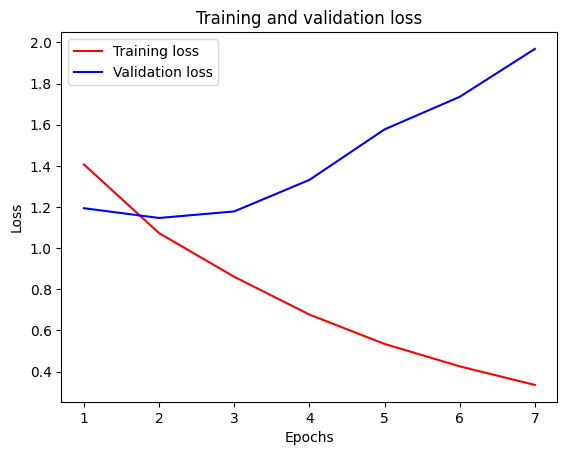

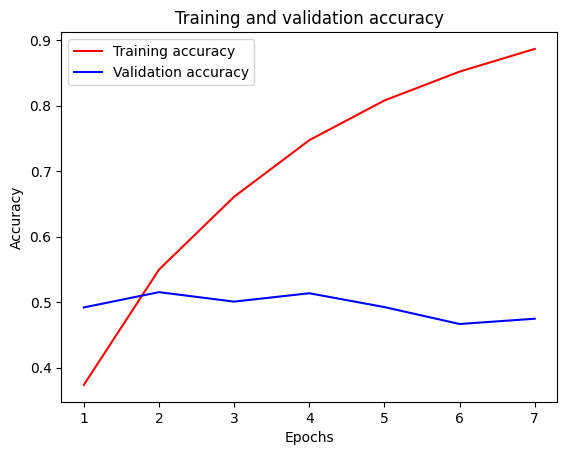

In [ ]:
import matplotlib.pyplot as plt

# Get training history
train_loss = rnn_history.history['loss']
val_loss = rnn_history.history['val_loss']
train_acc = rnn_history.history['accuracy']
val_acc = rnn_history.history['val_accuracy']
epochs = range(1, len(train_loss) + 1)

# Plot training and validation loss
plt.plot(epochs, train_loss, 'r-', label='Training loss')
plt.plot(epochs, val_loss, 'b-', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot training and validation accuracy
plt.figure()
plt.plot(epochs, train_acc, 'r-', label='Training accuracy')
plt.plot(epochs, val_acc, 'b-', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


# Instructions for Project 1 - Sentiment Analysis

Hello everyone, this is Zhaowei Wang. I am glad to host the first project. My email is *zwanggy@connect.ust.hk*. Feel free to send me an email if you have any problem regarding this project.

In this project, you will try to work on a sentiment analysis task.
You will build a model to predict the scores (a.k.a. the "label" column in datasets, from 1 to 5) of each review.
For each review, you are given a piece of text. You can consider the predicted variables as categorical, ordinal or numerical.

Just a kind note: The codes and techniques introduced in the previous tutorials may come in handy. You can refer to the .ipynb notebooks for details.

## Important dates, submission requirements and grading policy
**Important dates:**
- *March 16, 2024 (Saturday)*: Project starts
- *March 23, 2024 (Saturday)* Release the validation score of baselines
- *April 6, 2024, 23:59 (Saturday)*: `Submission Deadline`

**Submission requirements:**  
Each team leader is required to submit the groupNo.zip file on the Canvas. It shoud contain
- `pred.csv`: Predictions on test data (please make sure you can successfully evaluate your validation predictions on the validation data with the help of evaluate.py). The file should contain two so-called columns, which are `id`
and `label`.
- report (1-2 pages of pdf)
- code (Frameworks and programming languages are not restricted)

**Grading policy:**  
We will check your report with your code and your model performance (in terms of Accuracy) on the test set.

| Grade | Classifier (80%)                                                   | Report (20%)                      |
|-------|--------------------------------------------------------------------|-----------------------------------|
| 50%   | Example code in tutorials or in Project 1 without any modification | submission                        |
| 75%   | A method that can outperform the easy baseline  | algorithm you used                |
| 95%   | A method that can outperform the hard baseline                     | detailed explanation and analysis, such as explorative data analysis, hyperparameters and ablation studies  |
| 100%  | A method that can outperform the hard baseline with at least one excellent idea  | excellent ideas, detailed explanation and solid analysis |

## Instruction Content
In this notebook, you are provided with the code snippets to start with.

The content follows previous lectures and tutorials. But some potentially useful python packages are also mentioned.

1. Loading data and saving predictions
    1. Loading data
    1. Saving predictions to file
1. Preprocessing
    1. Text data processing recap
    1. Explorative data analysis
1. Learning Baselines

## 1. Loading data and saving predictions

The same as previous tutorials, we use `pandas` as the basic tool to load & dump the data.
The key ingredient of our operation is the `DataFrame` in pandas.

In [ ]:
import pandas as pd

In [ ]:
# if you use Google Colab, un-comment this cell, modify `path_to_data` if needed, and run to mount data to `data`
from google.colab import drive
drive.mount('/content/drive')

path_to_data = '/content/drive/My Drive/code/COMP4332/Project 1_Sentiment_Analysis/Project 1_Sentiment_Analysis/data'
!rm -f data
!ln -s '/content/drive/My Drive/code/COMP4332/Project 1_Sentiment_Analysis/Project 1_Sentiment_Analysis/data' data

##Bi-LSTM

In [ ]:
def load_data(split_name='train', columns=['id', 'text', 'label'], folder='data'):
    '''
        "split_name" may be set as 'train', 'valid' or 'test' to load the corresponding dataset.

        You may also specify the column names to load any columns in the .csv data file.
        Among many, "text" can be used as model input, and "label" column is the labels (sentiment).
    '''
    try:
        print(f"select [{', '.join(columns)}] columns from the {split_name} split")
        df = pd.read_csv(f'{folder}/{split_name}.csv')
        df = df.loc[:,columns]
        print("Success")
        return df
    except:
        print(f"Failed loading specified columns... Returning all columns from the {split_name} split")
        df = pd.read_csv(f'{folder}/{split_name}.csv')
        return df

In [ ]:
train_df = load_data('train', columns=['id', 'text', 'label'], folder='data')
valid_df = load_data('valid', columns=['id', 'text', 'label'], folder='data')
# the test set labels (the 'label' column) are unavailable! So the following code will instead return all columns
test_df = load_data('test_no_label', columns=['id', 'text'], folder='data')

In [ ]:
!pip install symspellpy

In [ ]:
!pip install sparknlp
!pip install pyspark

In [ ]:
import os
import nltk
import math
import pandas as pd
import numpy as np
import tensorflow as tf
import keras
import matplotlib.pyplot as plt
from collections import Counter
from itertools import chain
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score
from keras.models import Sequential, Model
from keras.layers import Dense, Activation, Embedding, Dropout, BatchNormalization, Input, Add, Concatenate,\
    Bidirectional, SimpleRNN, LSTM, GRU
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
import string

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')


stopwords = set(stopwords.words("english"))
ps = PorterStemmer()
lemmatizer = WordNetLemmatizer()

In [ ]:
from textblob import TextBlob
from symspellpy import SymSpell, Verbosity
import sparknlp
import re
import spacy
nlp = spacy.load('en_core_web_sm')
def spellingcorrection(tokens:list):
  symspell = SymSpell()
  correct_spellings = []
  for token in tokens:
      x = symspell.lookup(token,Verbosity.CLOSEST,max_edit_distance=2,include_unknown=True)[0].__str__()
      y = x.split(',')[0]
      correct_spellings.append(y)
  return correct_spellings

def lemmatize(tokens:list):
  return [lemmatizer.lemmatize(word) for word in tokens]

def punctuationRemoval(s:str):
  s = s.translate(str.maketrans('', '', string.punctuation))
  return s
def partialpunctuationRemoval(s:str):
  #s = s.translate(str.maketrans('', '', "\"#$%&'*+,-./<=>@[\]^_`{|}~"))
  s = s.translate(str.maketrans('', '', ",."))
  return s
def hyperlinksRemoval(s:str):
  s_processed = re.sub(r'^https?:\/\/.*[\r\n]*', '', s, flags=re.MULTILINE)
  p = re.compile(r'<.*?>')
  return p.sub("",s_processed)
def lower(s):
    """
    :param s: a string.
    return a string with lower characters
    Note that we allow the input to be nested string of a list.
    e.g.
    Input: 'Text mining is to identify useful information.'
    Output: 'text mining is to identify useful information.'
    """
    if isinstance(s, list):
        return [lower(t) for t in s]
    if isinstance(s, str):
        return s.lower()
    else:
        raise NotImplementedError("unknown datatype")

def tokenize(text):
    """
    :param text: a doc with multiple sentences, type: str
    return a word list, type: list
    e.g.
    Input: 'Text mining is to identify useful information.'
    Output: ['Text', 'mining', 'is', 'to', 'identify', 'useful', 'information', '.']
    """
    return nltk.word_tokenize(text)

def stem(tokens):
    """
    :param tokens: a list of tokens, type: list
    return a list of stemmed words, type: list
    e.g.
    Input: ['Text', 'mining', 'is', 'to', 'identify', 'useful', 'information', '.']
    Output: ['text', 'mine', 'is', 'to', 'identifi', 'use', 'inform', '.']
    """
    ### equivalent code
    # results = list()
    # for token in tokens:
    #     results.append(ps.stem(token))
    # return results

    return [ps.stem(token) for token in tokens]

def n_gram(tokens:list, n=1):
    """
    :param tokens: a list of tokens, type: list
    :param n: the corresponding n-gram, type: int
    return a list of n-gram tokens, type: list
    e.g.
    Input: ['text', 'mine', 'is', 'to', 'identifi', 'use', 'inform', '.'], 2
    Output: ['text mine', 'mine is', 'is to', 'to identifi', 'identifi use', 'use inform', 'inform .']
    """
    if n == 1:
      return tokens
    else:
      results = list()
      for i in range(len(tokens)-n+1):
          # tokens[i:i+n] will return a sublist from i th to i+n th (i+n th is not included)
          results.append(" ".join(str(v) for v in tokens[i:i+n]))
      return results

def filter_stopwords(tokens):
    """
    :param tokens: a list of tokens, type: list
    return a list of filtered tokens, type: list
    e.g.
    Input: ['text', 'mine', 'is', 'to', 'identifi', 'use', 'inform', '.']
    Output: ['text', 'mine', 'identifi', 'use', 'inform', '.']
    """
    ### equivalent code
    # results = list()
    # for token in tokens:
    #     if token not in stopwords and not token.isnumeric():
    #         results.append(token)
    # return results

    return [token for token in tokens if token not in stopwords and not token.isnumeric()]

import numpy as np

def get_onehot_vector(feats, feats_dict):
    """
    :param data: a list of features, type: list
    :param feats_dict: a dict from features to indices, type: dict
    return a feature vector,
    """
    # initialize the vector as all zeros
    vector = np.zeros(len(feats_dict), dtype=np.float)
    for f in feats:
        # get the feature index, return -1 if the feature is not existed
        f_idx = feats_dict.get(f, -1)
        if f_idx != -1:
            # set the corresponding element as 1
            vector[f_idx] = 1
    return vector

def get_index_vector(feats, feats_dict, max_len):
    """
    :param feats: a list of features, type: list
    :param feats_dict: a dict from features to indices, type: dict
    :param feats: a list of features, type: list
    return a feature vector,
    """
    # initialize the vector as all zeros
    vector = np.zeros(max_len, dtype=np.int64)
    for i, f in enumerate(feats):
        if i == max_len:
            break
        # get the feature index, return 1 (<unk>) if the feature is not existed
        f_idx = feats_dict.get(f, 1)
        vector[i] = f_idx
    return vector

In [ ]:
def get_feats_dict(feats, min_freq=-1, max_freq=-1, max_size=-1):
    """
    :param data: a list of features, type: list(list)
    :param min_freq: the lowest fequency that the fequency of a feature smaller than it will be filtered out, type: int
    :param max_freq: the highest fequency that the fequency of a feature larger than it will be filtered out, type: int
    :param max_size: the max size of feature dict, type: int
    return a feature dict that maps features to indices, sorted by frequencies
    # Counter document: https://docs.python.org/3.6/library/collections.html#collections.Counter
    """
    # count all features
    feat_cnt = Counter(feats) # ["text", "text", "mine"] --> {"text": 2, "mine": 1}
    if max_size > 0 and min_freq == -1 and max_freq == -1:
        valid_feats = ["<pad>", "<unk>"] + [f for f, cnt in feat_cnt.most_common(max_size-2)]
    else:
        valid_feats = ["<pad>", "<unk>"]
        for f, cnt in feat_cnt.most_common():
            if (min_freq == -1 or cnt >= min_freq) and \
                (max_freq == -1 or cnt <= max_freq):
                valid_feats.append(f)
    if max_size > 0 and len(valid_feats) > max_size:
        valid_feats = valid_feats[:max_size]
    print("Size of features:", len(valid_feats))

    # build a mapping from features to indices
    feats_dict = dict(zip(valid_feats, range(len(valid_feats))))
    return feats_dict

In [ ]:
def build_RNN(input_length, vocab_size, embedding_size,hidden_size, output_size,
              num_rnn_layers, num_mlp_layers,activation="tanh",
              dropout_rate=0.0,l2_reg=0.001,
              optimizer="Adam",learning_rate=0.001,
              metric="accuracy"):
    x = Input(shape=(input_length,))

    emb = Embedding(input_dim=vocab_size,output_dim=embedding_size,
        input_length=input_length, embeddings_initializer=keras.initializers.TruncatedNormal(mean=0.0, stddev=0.1, seed=0))(x)


    fn = LSTM
    h = emb
    for i in range(num_rnn_layers):
        is_last = (i == num_rnn_layers-1)

        h = keras.layers.Bidirectional(fn(hidden_size,
                kernel_initializer=keras.initializers.glorot_uniform(seed=0),
                recurrent_initializer=keras.initializers.Orthogonal(gain=1.0, seed=0),
                return_sequences=not is_last))(h)
        h = Dropout(dropout_rate, seed=0)(h)

    for i in range(num_mlp_layers-1):
        new_h = Dense(hidden_size,kernel_initializer=keras.initializers.he_normal(seed=0),
              bias_initializer="zeros",kernel_regularizer=keras.regularizers.l2(l2_reg))(h)

        new_h = BatchNormalization()(new_h)

        if i == 0:
            h = new_h
        else:
            h = Add()([h, new_h])
        h = Activation(activation)(h)
    y = Dense(output_size,activation="softmax",kernel_initializer=keras.initializers.he_normal(seed=0),bias_initializer="zeros")(h)


    optmizer = keras.optimizers.Adam(learning_rate=learning_rate)
    model = Model(x, y)
    model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=[metric])

    return model

In [ ]:
def negate_text(text):
    negation_words = ['not', "n't"]
    words = text.split()
    negated_words = []
    negating = False

    for word in words:
        if any(neg in word.lower() for neg in negation_words):
            negating = True
            negated_words.append('NOT_' + word)
        elif re.match(r'\w+[.!?]', word):
            # If punctuation encountered, stop negating
            negated_words.append(word)
            negating = False
        elif negating:
            negated_words.append('NOT_' + word)
        else:
            negated_words.append(word)

    return ' '.join(negated_words)

In [ ]:
train_labels = train_df['label'].values
valid_labels = valid_df['label'].values

train_feats = train_df['text'].map(hyperlinksRemoval).map(lower).map(negate_text).map(partialpunctuationRemoval).map(tokenize).map(filter_stopwords).map(lemmatize)
valid_feats = valid_df['text'].map(hyperlinksRemoval).map(lower).map(negate_text).map(partialpunctuationRemoval).map(tokenize).map(filter_stopwords).map(lemmatize)

In [ ]:
# build a mapping from features to indices
min_freq = 0
feats_dict = get_feats_dict(
    chain.from_iterable(train_feats),
    min_freq=min_freq)
print("feats_dict:", feats_dict)

Size of features: 22811
feats_dict: {'<pad>': 0, '<unk>': 1, 'movie': 2, '!': 3, 'NOT_not': 4, "'s": 5, 'good': 6, "n't": 7, 'great': 8, 'NOT_the': 9, 'one': 10, 'time': 11, 'film': 12, 'NOT_it': 13, 'love': 14, 'story': 15, 'like': 16, 'NOT_a': 17, 'watch': 18, 'NOT_to': 19, "''": 20, 'NOT_of': 21, 'NOT_this': 22, 'classic': 23, 'dvd': 24, 'NOT_i': 25, 'would': 26, 'really': 27, 'well': 28, 'NOT_as': 29, 'NOT_but': 30, 'acting': 31, '?': 32, '``': 33, 'NOT_and': 34, 'NOT_was': 35, 'see': 36, 'old': 37, 'better': 38, 'NOT_do': 39, 'best': 40, 'still': 41, 'watching': 42, 'NOT_in': 43, 'much': 44, 'actor': 45, 'NOT_for': 46, 'fun': 47, 'NOT_movie': 48, ')': 49, 'NOT_did': 50, 'year': 51, 'funny': 52, 'first': 53, 'get': 54, 'NOT_is': 55, 'star': 56, '(': 57, 'watched': 58, 'enjoyed': 59, 'bad': 60, 'little': 61, 'seen': 62, 'could': 63, 'version': 64, 'made': 65, 'favorite': 66, 'never': 67, 'plot': 68, 'always': 69, 'kid': 70, 'loved': 71, 'character': 72, 'lot': 73, 'NOT_good': 74, 'q

In [ ]:
max_len = 200

train_feats_matrix = np.vstack(
    [get_index_vector(f, feats_dict, max_len) for f in train_feats])
valid_feats_matrix = np.vstack(
    [get_index_vector(f, feats_dict, max_len) for f in valid_feats])

num_classes = max(train_labels)

train_label_matrix = keras.utils.to_categorical(train_labels-1, num_classes=num_classes)
valid_label_matrix = keras.utils.to_categorical(valid_labels-1, num_classes=num_classes)

In [ ]:
model = build_RNN(input_length=max_len,vocab_size=len(feats_dict),embedding_size=100,
          hidden_size=100,output_size=num_classes,num_rnn_layers=1,
          num_mlp_layers=1,dropout_rate=0.6,
          l2_reg=0.01)

checkpointer = keras.callbacks.ModelCheckpoint(
    filepath=os.path.join("models", "weights.hdf5"),
    monitor="val_accuracy",
    verbose=0,
    save_best_only=True)
earlystopping =  keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    verbose=0)
np.random.seed(0)
tf.random.set_seed(0)
rnn_history = model.fit(train_feats_matrix, train_label_matrix,
                    validation_split=0.2,
                    epochs=100, batch_size=64, verbose=1,
                    callbacks=[checkpointer, earlystopping])
model = keras.models.load_model(os.path.join("models", "weights.hdf5"))

train_score = model.evaluate(train_feats_matrix, train_label_matrix,
                             batch_size=100)
valid_score = model.evaluate(valid_feats_matrix, valid_label_matrix,
                            batch_size=100)
print("training loss:", train_score[0], "training accuracy", train_score[1])
print("valid loss:", valid_score[0], "valid accuracy", valid_score[1])

Epoch 1/100
225/225 [==============================] - 192s 832ms/step - loss: 1.4068 - accuracy: 0.3737 - val_loss: 1.1941 - val_accuracy: 0.4919
Epoch 2/100
225/225 [==============================] - 194s 863ms/step - loss: 1.0729 - accuracy: 0.5497 - val_loss: 1.1467 - val_accuracy: 0.5153
Epoch 3/100
225/225 [==============================] - 178s 790ms/step - loss: 0.8607 - accuracy: 0.6609 - val_loss: 1.1786 - val_accuracy: 0.5008
Epoch 4/100
225/225 [==============================] - 181s 805ms/step - loss: 0.6771 - accuracy: 0.7472 - val_loss: 1.3317 - val_accuracy: 0.5136
Epoch 5/100
225/225 [==============================] - 179s 796ms/step - loss: 0.5344 - accuracy: 0.8078 - val_loss: 1.5773 - val_accuracy: 0.4925
Epoch 6/100
225/225 [==============================] - 179s 795ms/step - loss: 0.4254 - accuracy: 0.8519 - val_loss: 1.7357 - val_accuracy: 0.4667
Epoch 7/100
20/20 [==============================] - 5s 264ms/step - loss: 1.1619 - accuracy: 0.5020
training loss: 0.

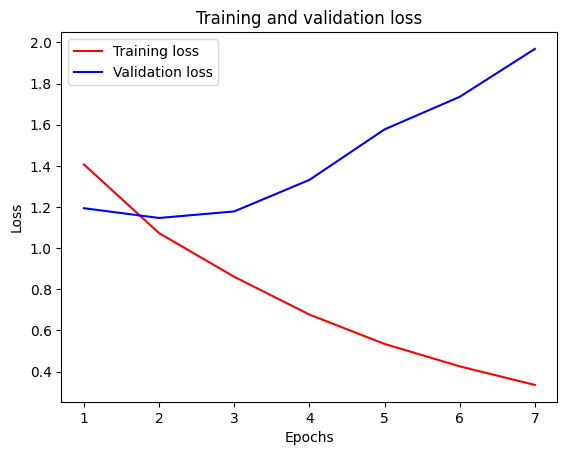

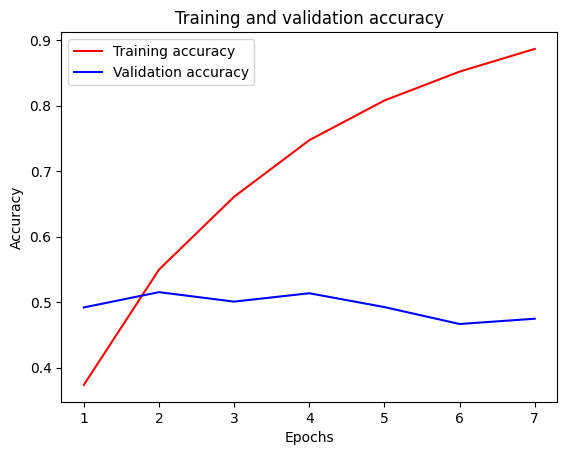

In [ ]:
import matplotlib.pyplot as plt

# Get training history
train_loss = rnn_history.history['loss']
val_loss = rnn_history.history['val_loss']
train_acc = rnn_history.history['accuracy']
val_acc = rnn_history.history['val_accuracy']
epochs = range(1, len(train_loss) + 1)

# Plot training and validation loss
plt.plot(epochs, train_loss, 'r-', label='Training loss')
plt.plot(epochs, val_loss, 'b-', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot training and validation accuracy
plt.figure()
plt.plot(epochs, train_acc, 'r-', label='Training accuracy')
plt.plot(epochs, val_acc, 'b-', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
